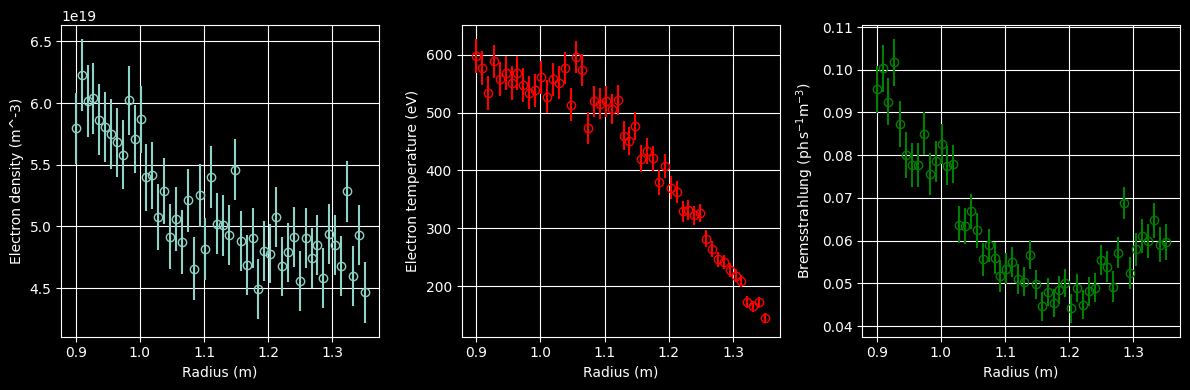

In [2]:
from numpy import ndarray

import matplotlib.pyplot as plt
from example_data import brem_measurements, brem_sigma, measurement_radius
from example_data import te_measurements, ne_measurements, te_sigma, ne_sigma

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

data_style = dict(marker="o", linestyle="none", markerfacecolor="none")

ax1.errorbar(measurement_radius, ne_measurements, yerr=ne_sigma, c="C0", **data_style)
ax1.set_xlabel("Radius (m)")
ax1.set_ylabel("Electron density (m^-3)")
ax1.grid()

ax2.errorbar(measurement_radius, te_measurements, yerr=te_sigma, c="red", **data_style)
ax2.set_xlabel("Radius (m)")
ax2.set_ylabel("Electron temperature (eV)")
ax2.grid()

ax3.errorbar(measurement_radius, brem_measurements, yerr=brem_sigma, c="green", **data_style)
ax3.set_xlabel("Radius (m)")
ax3.set_ylabel(r"Bremsstrahlung $(\mathrm{ph \, s^{-1} m^{-3})}$")
ax3.grid()

fig.tight_layout()
plt.show()

## Defining diagnostic models
In `midas`, diagnostic models are classes which inherit from an abstract base-class `DiagnosticModel`. This class can fully implement a forward-model of a diagnostic, or act as a light wrapper around a model implemented elsewhere, allowing that model to interact with `midas`.

In this example, we will use an existing physics code which models the bremsstrahlung emission $\mathcal{E}$ as
$$
\mathcal{E} = a Z_{\mathrm{eff}} n_e^2 \frac{G(T_e)}{\lambda^2 \sqrt{T_e}} \exp{\left[ - \frac{b}{\lambda T_e}\right]}.
$$
Here $a$, $b$ are known constants, and for simplicity we'll assume our bremsstrahlung measurements were collected at a single fixed wavelength $\lambda$.

Therefore, to make predictions of our measured bremsstrahlung, we need to specify the Z-effective $Z_{\mathrm{eff}}$, electron temperature $T_e$ and electron density $n_e$ at the appropriate radial positions.

To communicate to `midas` that the values of these fields are required inputs to the model, we use the `self.fields` instance attribute of our model class. `self.fields` is always an instance of the `Fields` class, which accepts a series of `FieldRequests` as arguments. Each instance of `FieldRequest` allows us to request the values of a particular field at a given set of coordinates.

The `DiagnosticModel` base-class also has two abstract methods, `predictions` and `predictions_and_jacobians`, which `midas` will call when evaluating the posterior log-probability or its derivative. The values of any fields or parameters required by the model are passed to these methods using the names of the fields and parameters.

We can now implement a diagnostic model for the Bremsstrahlung measurements as follows:

In [1]:
# import our existing physics model
from diagnostics import bremsstrahlung_model, bremsstrahlung_jacobian

from midas import Fields, FieldRequest, Parameters
from midas.models import DiagnosticModel


class BremsstrahlungModel(DiagnosticModel):
    def __init__(self, radius: ndarray, wavelength: float):
        self.wavelength = wavelength

        # Set the 'fields' attribute to request the field values the model needs
        self.fields = Fields(
            FieldRequest(name="te", coordinates={"radius": radius}),
            FieldRequest(name="ne", coordinates={"radius": radius}),
            FieldRequest(name="z_eff", coordinates={"radius": radius}),
        )

        # The model has no additional parameters, so an empty 'Parameters'
        # instance is given
        self.parameters = Parameters()

    def predictions(self, te: ndarray, ne: ndarray, z_eff: ndarray) -> ndarray:
        # call model / return predictions
        return bremsstrahlung_model(
            Te=te,
            Ne=ne,
            zeff=z_eff,
            wavelength=self.wavelength,
        )

    def predictions_and_jacobians(
            self, te: ndarray, ne: ndarray, z_eff: ndarray
    ) -> tuple[ndarray, dict[str, ndarray]]:
        return bremsstrahlung_jacobian(
            Te=te,
            Ne=ne,
            zeff=z_eff,
            wavelength=self.wavelength,
        )


NameError: name 'ndarray' is not defined

In [ ]:


brem_forward_model = BremsstrahlungModel(
    radius=measurement_radius,
    wavelength=569e-9,
)


In [ ]:
from midas.likelihoods import GaussianLikelihood

brem_likelihood = GaussianLikelihood(
    y_data=brem_measurements,
    sigma=brem_sigma,
)


brem_diagnostic = DiagnosticLikelihood(
    likelihood=brem_likelihood,
    diagnostic_model=brem_model,
    name="brem_diagnostic"